In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [9]:
def make_combined_df(
        human_corrected_csv_path,
        algo_csv_paths,
        algo_names,
):
    # Check that names are unique
    assert len(algo_names) == len(set(algo_names)), "Algorithm names must be unique"        
    human_corrected_df = pd.read_csv(human_corrected_csv_path, comment="#")
    human_corrected_df = human_corrected_df.rename(columns={"tension": "human_corrected_tension", "confidence": "human_corrected_uncertainty"})

    df = human_corrected_df
    algo_df_list = [pd.read_csv(algo_csv_path, comment="#") for algo_csv_path in algo_csv_paths]
    for algo_df, algo_name in zip(algo_df_list, algo_names):
        algo_df = algo_df.rename(columns={"tension": f"algo_{algo_name}_tension", "confidence": f"algo_{algo_name}_uncertainty"})
        df = pd.merge(df, algo_df, on=["scan_id", "dwa_channel", "side", "layer", "apa_channel", "segment", "headboard_num", "datetime"])
    
    return df

In [14]:
def plot_algo_comparison(combined_df, algo_names, layer="U", algo_plot_labels=None, ax=None, max_uncertainty=0.5):
    if algo_plot_labels is None:
        algo_plot_labels = algo_names
    assert len(algo_names) == len(algo_plot_labels), "Must provide a plot label for each algorithm"
    if ax is None:
        fig, ax = plt.subplots()
    for algo_name, algo_plot_label in zip(algo_names, algo_plot_labels):
        layer_mask = combined_df["layer"] == layer
        error = combined_df[layer_mask][f"human_corrected_tension"] - combined_df[layer_mask][f"algo_{algo_name}_tension"]
        median_error = np.nanmedian(error)
        print(f"Median error for algorithm: {algo_name} is {median_error}")
        error = np.abs(error - median_error)
        uncertainty = combined_df[layer_mask][f"algo_{algo_name}_uncertainty"]
        mask = uncertainty < max_uncertainty
        error = error[mask]
        # plot cumulative samples below error as a function of the error
        ax.plot(np.sort(error), np.arange(len(error)), label=algo_plot_label)
    # set labels
    ax.set_xlabel("Absolute Error w.r.t. Human Labeling (N)")
    ax.set_ylabel("Cumulative Number of Segments")
    ax.grid()
    ax.set_title(f"Layer {layer}")
    return ax


In [11]:
import os
# List all csv files in current directory
csv_files = [f for f in os.listdir("../") if f.endswith(".csv")]
csv_files

['apa4_algo_v2_pop50_correlated.csv',
 'apa4_algo_v2_pop100_latinhypercube.csv',
 'apa4_algo_v2_pop50_latinhypercube.csv',
 'apa4_algo_v2_pop50_latinhypercube_ds_4.csv',
 'test_v1.csv',
 'apa4_algo_v1.csv',
 'apa4_algo_v2_tuned_settings_local_fit.csv',
 'apa4_algo_v2_tuned_settings.csv',
 'apa4_algo_v2_tuned_dof_free_tensions.csv',
 'apa4_algo_v2_tuned_dof_free_tensions_with_unc.csv',
 'apa4_algo_v2_pop50_sobol.csv',
 'apa4_algo_v2_tuned_settings_2.csv',
 'apa4_algo_v2_tuned_dof_static_tensions.csv',
 'apa4_algo_v2_pop50_ignorefirs_5.csv',
 'apa4_algo_v2_tuned_settings_3_sobol.csv']

In [12]:
combined_df = make_combined_df(
    human_corrected_csv_path="human_corrected_apa4_dwa5_XUVG.csv",
    algo_csv_paths=[
        "../apa4_algo_v1.csv",
        "../apa4_algo_v2_tuned_dof_free_tensions_with_unc.csv"
    ],
    algo_names=[
        "v1",
        "v2"
    ],
)
combined_df

,stage,scan_id,datetime,side,layer,headboard_num,apa_channel,dwa_channel,segment,human_corrected_tension,human_corrected_uncertainty,submitted,algo_ver,algo_v1_tension,algo_v1_uncertainty,algo_v2_tension,algo_v2_uncertainty
0,Winding,20230208T142053_U_B_8_98-100-102-104-106-108-1...,2023-02-08 14:20:53,B,U,8,98,0,98,6.542040,NaN,Manual,NaN,NaN,NaN,7.182257,0.270244
1,Winding,20230208T142053_U_B_8_98-100-102-104-106-108-1...,2023-02-08 14:20:53,B,U,8,98,0,498,5.868682,NaN,Manual,NaN,NaN,NaN,5.861004,0.270244
2,Winding,20230208T142053_U_B_8_98-100-102-104-106-108-1...,2023-02-08 14:20:53,B,U,8,98,0,898,7.156684,NaN,Manual,NaN,NaN,NaN,6.384892,0.270244
3,Winding,20230208T142053_U_B_8_98-100-102-104-106-108-1...,2023-02-08 14:20:53,B,U,8,100,1,100,6.615110,NaN,Manual,NaN,6.62,0.0,6.517804,0.270244
4,Winding,20230208T142053_U_B_8_98-100-102-104-106-108-1...,2023-02-08 14:20:53,B,U,8,100,1,500,6.469525,NaN,Manual,NaN,6.60,0.0,6.632526,0.771899
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2624,Winding,20230208T185357_U_A_10_34-36-38-40-434-436-438...,2023-02-08 18:53:57,A,U,10,38,2,438,6.392809,NaN,Manual,NaN,6.39,0.0,6.390740,0.650431
2625,Winding,20230208T185357_U_A_10_34-36-38-40-434-436-438...,2023-02-08 18:53:57,A,U,10,38,2,838,7.953737,NaN,Manual,NaN,7.45,0.0,7.124819,0.270244
2626,Winding,20230208T185357_U_A_10_34-36-38-40-434-436-438...,2023-02-08 18:53:57,A,U,10,40,3,40,6.489331,NaN,Manual,NaN,6.49,0.0,3.467737,0.270244
2627,Winding,20230208T185357_U_A_10_34-36-38-40-434-436-438...,2023-02-08 18:53:57,A,U,10,40,3,440,6.020878,NaN,Manual,NaN,6.36,0.0,6.189291,0.270244


Median error for algorithm: v1 is -0.0032559740368052204
Median error for algorithm: v2 is -0.00042537523318397774
Median error for algorithm: v1 is 0.0005127896898331485
Median error for algorithm: v2 is 0.0004978299853859447


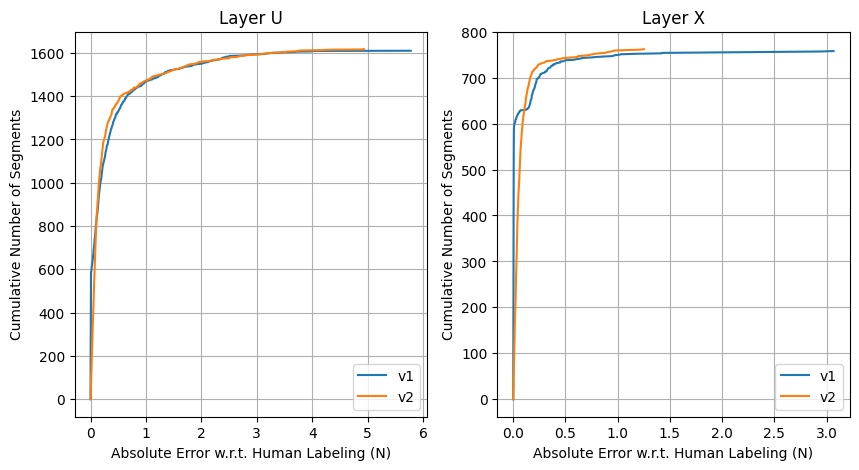

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
for ax, layer in zip([ax1, ax2], ["U", "X"]):
    plot_algo_comparison(
        combined_df=combined_df,
        algo_names=[
            "v1",
            "v2",
        ],
        layer=layer,
        ax=ax,
        max_uncertainty=0.7,
    )
    ax.legend(loc="lower right")
# plt.savefig("performance_new_algo_layer_u.pdf")

In [16]:
def plot_algo_comparison_scatter(combined_df, algo_names, layer="U", algo_plot_labels=None, ax=None):
    if algo_plot_labels is None:
        algo_plot_labels = algo_names
    assert len(algo_names) == len(algo_plot_labels), "Must provide a plot label for each algorithm"
    if ax is None:
        fig, ax = plt.subplots()
    for algo_name, algo_plot_label in zip(algo_names, algo_plot_labels):
        layer_mask = combined_df["layer"] == layer
        error = combined_df[layer_mask][f"human_corrected_tension"] - combined_df[layer_mask][f"algo_{algo_name}_tension"]
        median_error = np.nanmedian(error)
        print(f"Median error for algorithm: {algo_name} is {median_error}")
        error = error - median_error
        
        sns.scatterplot(x=combined_df[layer_mask][f"human_corrected_tension"], y=error, label=algo_plot_label, ax=ax)
    ax.set_xlabel("Human Corrected Tension (N)")
    ax.set_ylabel("Error w.r.t. Human Labeling (N)")
    return ax

Median error for algorithm: v1 is -0.0032559740368052204
Median error for algorithm: apa4_algo_v2_pop50_latinhypercube is 0.003910738499547151
Median error for algorithm: apa4_algo_v2_tuned_dof_free_tensions is 0.06123096646373938


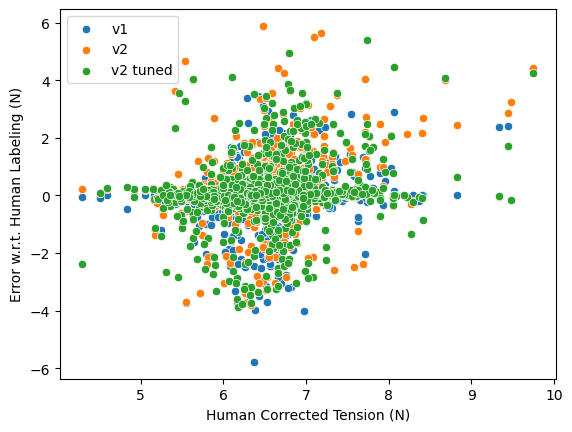

In [17]:
ax = plot_algo_comparison_scatter(
    combined_df=combined_df,
    algo_names=["v1", "apa4_algo_v2_pop50_latinhypercube", "apa4_algo_v2_tuned_dof_free_tensions"],
    layer="U",
    algo_plot_labels=["v1", "v2", "v2 tuned"],
)


In [22]:
def plot_algo_comparison_hist(combined_df, algo_names, layer="U", algo_plot_labels=None, ax=None, error_threshold=0.01):
    if algo_plot_labels is None:
        algo_plot_labels = algo_names
    assert len(algo_names) == len(algo_plot_labels), "Must provide a plot label for each algorithm"
    if ax is None:
        fig, ax = plt.subplots()
    for algo_name, algo_plot_label in zip(algo_names, algo_plot_labels):
        layer_mask = combined_df["layer"] == layer
        error = combined_df[layer_mask][f"human_corrected_tension"] - combined_df[layer_mask][f"algo_{algo_name}_tension"]
        median_error = np.nanmedian(error)
        print(f"Median error for algorithm: {algo_name} is {median_error}")
        error = error - median_error
        
        # Algorithm v1 has a large number of events where the "human labeling" is exactly on top of the algorithm tension.
        # We only want to include the scans where the error is above a threshold
        error = error[np.abs(error) > error_threshold]
        sns.histplot(error, label=algo_plot_label, ax=ax)
    ax.set_xlabel("Error w.r.t. Human Labeling (N)")
    ax.legend(loc="upper right")
    return ax

Median error for algorithm: v1 is -0.0032559740368052204
Median error for algorithm: apa4_algo_v2_pop50_latinhypercube is 0.003910738499547151
Median error for algorithm: apa4_algo_v2_tuned_dof_free_tensions is 0.06123096646373938


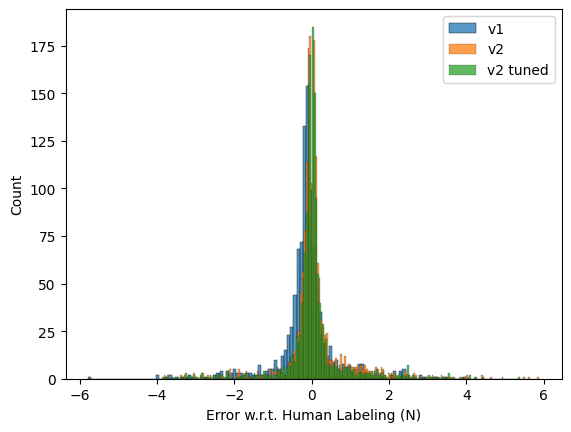

In [26]:
ax = plot_algo_comparison_hist(
    combined_df=combined_df,
    algo_names=["v1", "apa4_algo_v2_pop50_latinhypercube", "apa4_algo_v2_tuned_dof_free_tensions"],
    layer="U",
    algo_plot_labels=["v1", "v2", "v2 tuned"],
)
# ax.set_yscale("log")